---
### Closed-Form Solution with Mass Action Kinetics

Solve for lambda and Y with built-in Python library

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a = 23.8
k = 0.01
r = a / k  # r = a/k
N = 1000
# b_min, b_max, b_large = 5e-6, 0.001, False
b_min, b_max, b_large = 1e-4, 2e-2, False   # Use False for small b computation
b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)

### Softmax transformation

In [73]:
from scipy.special import logsumexp
def softmax_partition(u):
    u_val = float(u)
    logZ = logsumexp([u_val, 0.0])
    theta1 = np.exp(u_val - logZ)
    theta2 = np.exp(-logZ)
    return theta1, theta2

# System
def BioSystemMA2(theta, b_val):
    term_Y1 = (r * theta[1]) / (b_val * theta[0])
    Y1 = 1 / (1 + term_Y1)
    Y2 = (r * theta[1] / b_val) * Y1
    Y3 = 1 - Y1 - Y2
    lambda_val = b_val * Y2
    return np.array([b_val, theta[0], theta[1], Y1, Y2, Y3, lambda_val])

def objective_softmax(u, b_val): return -BioSystemMA2(softmax_partition(u), b_val)[6]   # objective function

# Optimization
def optimize_for_b_softmax(b_val, tol=1e-6, gtol=1e-8, maxiter=2000):
    if b_large:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=0.0,
            bounds=[(-10, 10)],
            method='L-BFGS-B',   # L-BFGS-B has bounds
            tol=tol,
            options={
                'gtol': gtol,
                'maxiter': maxiter,
                'disp': False
            }
        )
    else:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=0.0,
            method='Powell',   # derivative-free method
            tol=tol,
            options={
                'maxiter': maxiter,
                'disp': False
            }
        )
    if result.success or (np.abs(result.fun) < 1e-6):
        bio_result = BioSystemMA2(softmax_partition(result.x), b_val)
        lambda_max_expected = b_val * 1.0  # lambda = b*Y2, and Y2 <= 1
        if (bio_result[6] >= 0 and bio_result[6] <= lambda_max_expected):
            return bio_result
    return None


# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = np.array([r for r in results if r is not None])
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

(b_arr, theta1_arr, theta2_arr, Y1_arr, Y2_arr, Y3_arr, lambda_arr) = results.T   # The "Pythonic" way using tuple unpacking!

Optimization completed in 1.13 seconds.


### Plot the result

,Nutrient level,Growth rate,Y1,Y2,Y3,Sum_Y,Approx. Sum_Y
0,0.000100,0.000100,0.000205,0.999590,0.000205,1.0,None
1,0.000101,0.000100,0.000205,0.999589,0.000205,1.0,None
2,0.000101,0.000101,0.000206,0.999588,0.000206,1.0,None
3,0.000102,0.000102,0.000207,0.999587,0.000207,1.0,None
4,0.000102,0.000102,0.000207,0.999586,0.000207,1.0,None
...,...,...,...,...,...,...,...
995,0.019580,0.019468,0.002860,0.994288,0.002852,1.0,None
996,0.019684,0.019572,0.002868,0.994273,0.002859,1.0,None
997,0.019789,0.019675,0.002875,0.994258,0.002867,1.0,None
998,0.019894,0.019780,0.002883,0.994243,0.002875,1.0,None


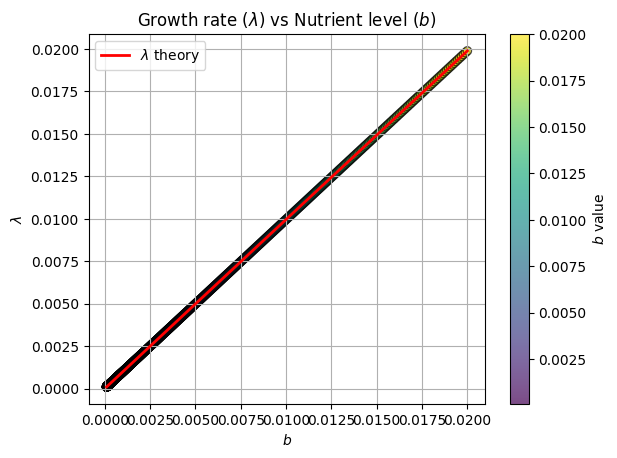

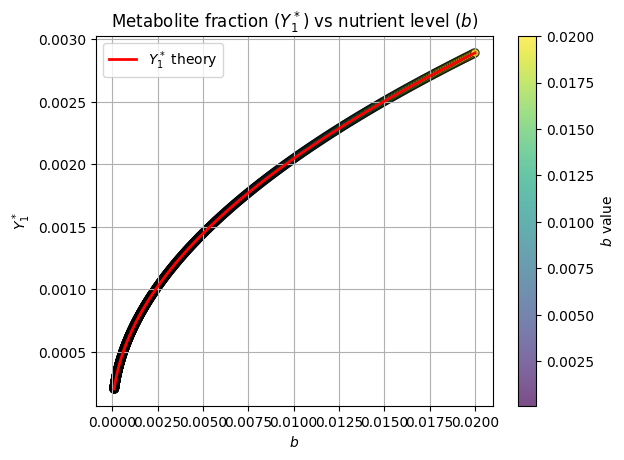

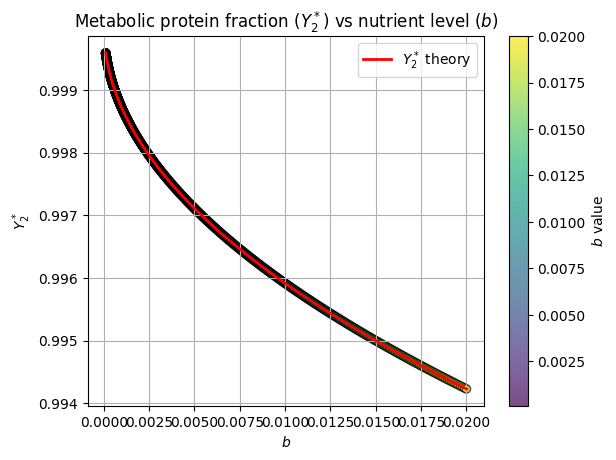

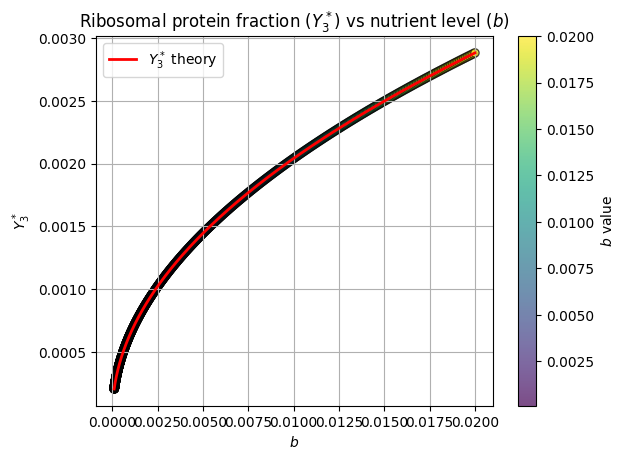

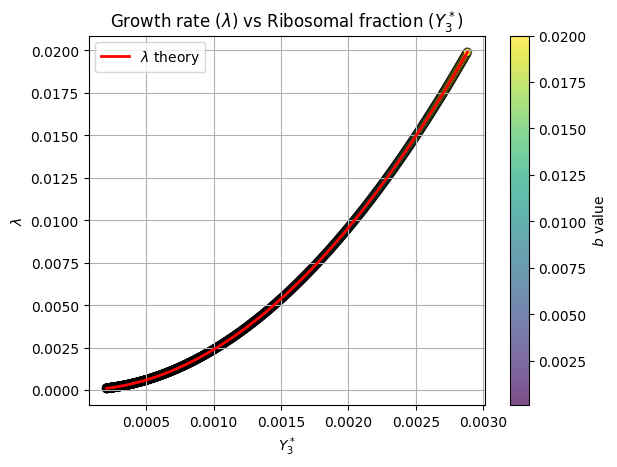

In [77]:
# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Y1": Y1_arr,
    "Y2": Y2_arr,
    "Y3": Y3_arr,
    "Sum_Y": Y1_arr + Y2_arr + Y3_arr,
    "Approx. Sum_Y": None
})
display(df)


Y1_b_theory_arr = np.sqrt(b_arr/r)/(1 + np.sqrt(b_arr/r))
Y2_b_theory_arr = 1/(1 + np.sqrt(b_arr/r))**2
Y3_b_theory_arr = 1 - Y1_b_theory_arr - Y2_b_theory_arr
Small_b_theory_arr = Y1_b_theory_arr
Large_b_theory_arr = Y2_b_theory_arr + Y3_b_theory_arr
lambda_b_theory_arr = b_arr / (1 + np.sqrt(b_arr/r))**2
lambda_Y3_theory_arr = r*( 0.5 + np.sqrt((0.5 - Y3_arr)**2 - Y3_arr**2) )**2
Y3_lambda_theory_arr = np.sqrt(lambda_arr/r) - lambda_arr/r

# Growth rate to nutrient level (b)
plt.figure()
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
if lambda_b_theory_arr is not None:
    plt.plot(b_arr, lambda_b_theory_arr, lw=2, label=r'$\lambda$ theory', linestyle='-', color='red')
plt.xlabel(r'$b$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend()
plt.grid(True)
plt.show()

# Metabolite fraction (Y1) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y1_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
if Y1_b_theory_arr is not None:
    plt.plot(b_arr, Y1_b_theory_arr, lw=2, label=r'$Y_1^*$ theory', linestyle='-', color='red')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_1^*$')
plt.title(r'Metabolite fraction ($Y_1^*$) vs nutrient level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# Metabolic protein fraction (Y2) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y2_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
if Y2_b_theory_arr is not None:
    plt.plot(b_arr, Y2_b_theory_arr, lw=2, label=r'$Y_2^*$ theory', linestyle='-', color='red')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_2^*$')
plt.title(r'Metabolic protein fraction ($Y_2^*$) vs nutrient level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# Ribosomal protein fraction (Y3) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y3_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
if Y3_b_theory_arr is not None:
    plt.plot(b_arr, Y3_b_theory_arr, lw=2, label=r'$Y_3^*$ theory', linestyle='-', color='red')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_3^*$')
plt.title(r'Ribosomal protein fraction ($Y_3^*$) vs nutrient level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y3)
plt.figure()
scatter = plt.scatter(Y3_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
# if lambda_Y3_theory_arr is not None:
#     plt.plot(Y3_arr, lambda_Y3_theory_arr, lw=2, label=r'$\lambda$ theory', linestyle='-', color='red')
if Y3_lambda_theory_arr is not None:
    plt.plot(Y3_lambda_theory_arr, lambda_arr, lw=2, label=r'$\lambda$ theory', linestyle='-', color='red')
plt.xlabel(r'$Y_3^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_3^*$)')
plt.grid(True)
plt.legend()
plt.show()



Data saved to PP2_MA_output.csv (1000 rows)


,Nutrient level,Growth rate,$\theta_1$,$\theta_2$,$p = \frac{\theta_2}{\theta_1}$,$\sum \theta$
0,0.000100,0.000100,0.999795,0.000205,0.000205,1.0
1,0.000101,0.000100,0.999795,0.000205,0.000206,1.0
2,0.000101,0.000101,0.999794,0.000206,0.000206,1.0
3,0.000102,0.000102,0.999793,0.000207,0.000207,1.0
4,0.000102,0.000102,0.999793,0.000207,0.000207,1.0
5,0.000103,0.000103,0.999792,0.000208,0.000208,1.0
6,0.000103,0.000103,0.999792,0.000208,0.000208,1.0
7,0.000104,0.000104,0.999791,0.000209,0.000209,1.0
8,0.000104,0.000104,0.999791,0.000209,0.000209,1.0
9,0.000105,0.000105,0.999790,0.000210,0.000210,1.0


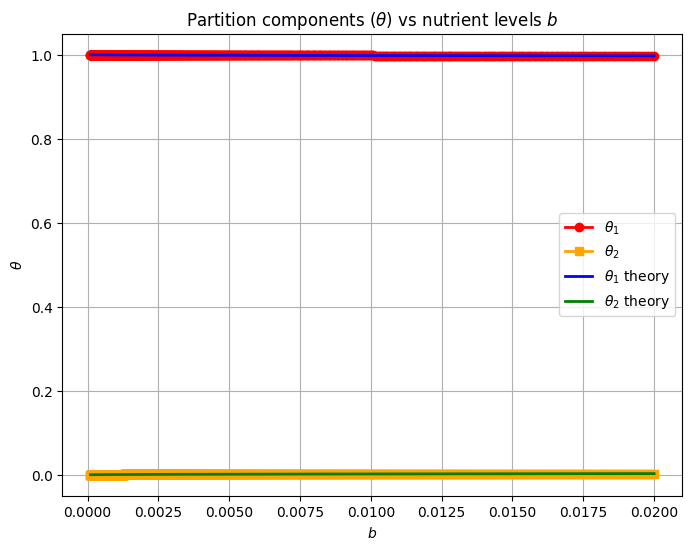

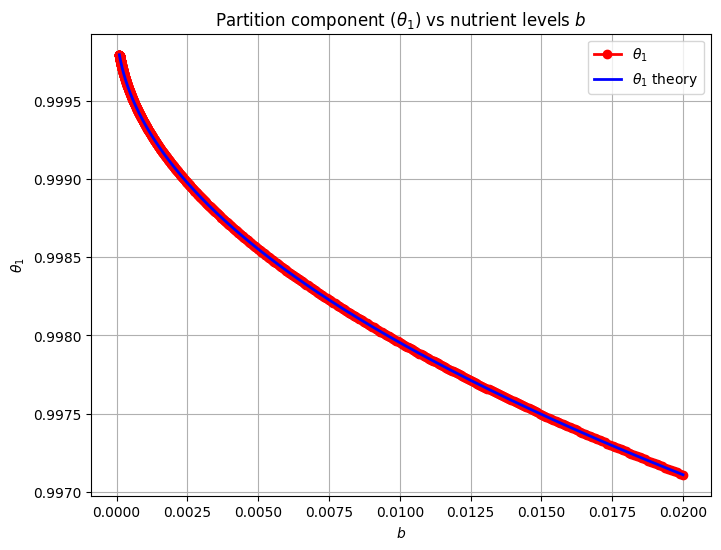

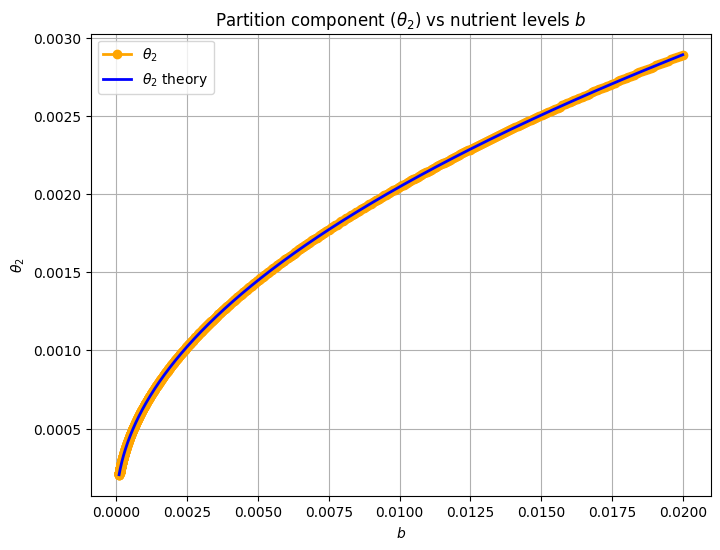

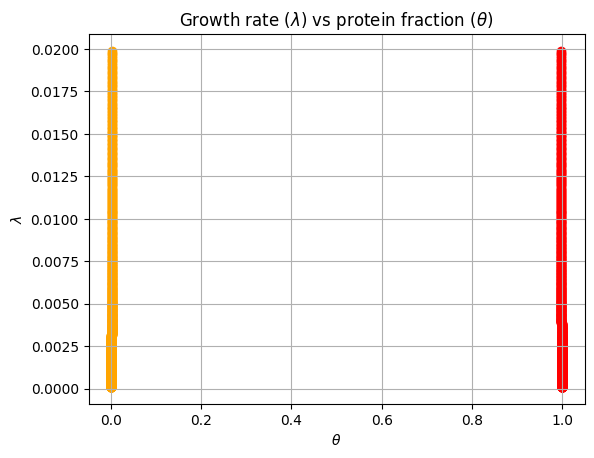

In [75]:
# Approximate Theory (to be determined for Mass Action kinetics)
theta1_approx_arr = 1 / (1 + np.sqrt(b_arr/r))
theta2_approx_arr = 1 - theta1_approx_arr

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    r"$\theta_1$": theta1_arr,
    r"$\theta_2$": theta2_arr,
    r"$p = \frac{\theta_2}{\theta_1}$": theta2_arr / theta1_arr,
    r"$\sum \theta$": theta1_arr + theta2_arr,
})

# Save to CSV file
df.to_csv('PP2_MA_output.csv', index=False, float_format='%.6f')
print(f"Data saved to PP2_MA_output.csv ({len(df)} rows)")

# Display first few rows
display(df.head(10))


# Partition components to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='s', color='orange')
if theta1_approx_arr is not None:
    plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$ theory', linestyle='-', color='blue')
    plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$ theory', linestyle='-', color='green')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta1 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
if theta1_approx_arr is not None:
    plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_1$')
plt.title(r'Partition component ($\theta_1$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta2 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='o', color='orange')
if theta2_approx_arr is not None:
    plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_2$')
plt.title(r'Partition component ($\theta_2$) vs nutrient levels $b$')
plt.grid(True)
# plt.ylim(0.0, 0.01)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='red')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='orange')
plt.xlabel(r'$\theta$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)')
plt.grid(True)
plt.show()

### Small and Large Molecules
The small molecules include metabolites and precursors. Large molecules include different types of proteins.

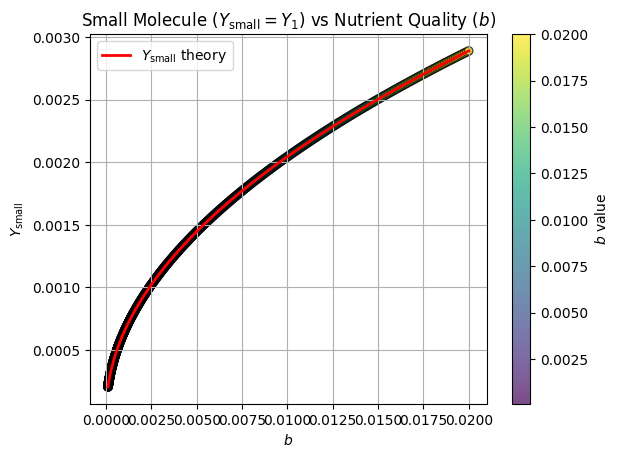

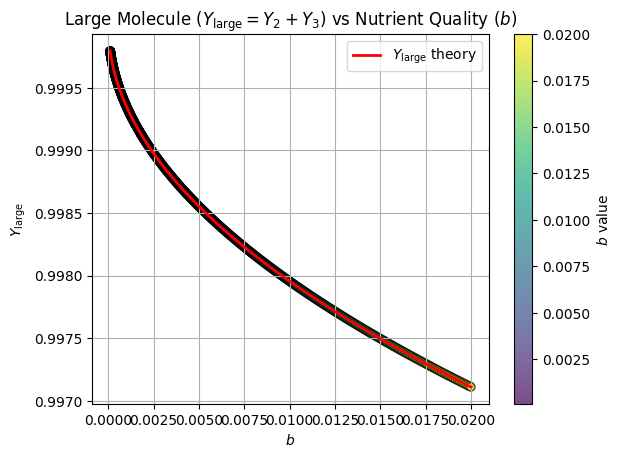

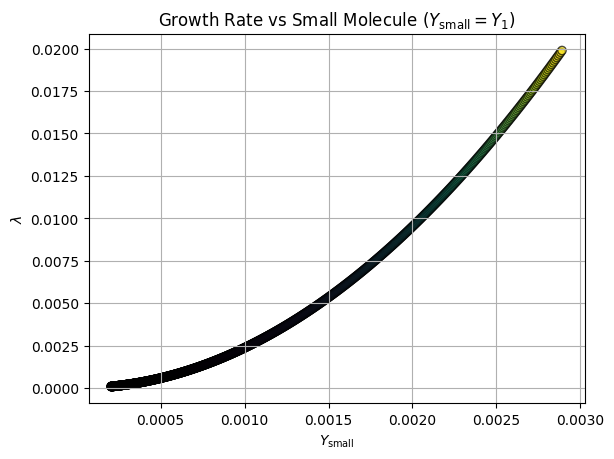

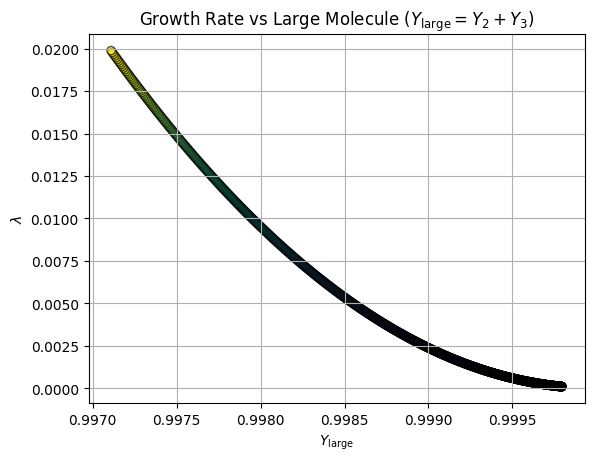

In [76]:
# Discuss different molecdule sizes
small_mol_arr = Y1_arr
large_mol_arr = Y2_arr + Y3_arr

# Small molecule (metabolites and a.a.'s) fraction (Y1) to b
plt.figure()
scatter = plt.scatter(b_arr, small_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
if Small_b_theory_arr is not None:
    plt.plot(b_arr, Small_b_theory_arr, lw=2, label=r'$Y_\text{small}$ theory', linestyle='-', color='red')
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{small}$')
plt.title(r'Small Molecule ($Y_\text{small} = Y_1$) vs Nutrient Quality ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# Large molecule (proteins) fraction (Y2 + Y3) to b
plt.figure()
scatter = plt.scatter(b_arr, large_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
if Large_b_theory_arr is not None:
    plt.plot(b_arr, Large_b_theory_arr, lw=2, label=r'$Y_\text{large}$ theory', linestyle='-', color='red')
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{large}$')
plt.title(r'Large Molecule ($Y_\text{large} = Y_2 + Y_3$) vs Nutrient Quality ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth Rate vs Small Molecule fraction
plt.figure()
scatter = plt.scatter(small_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$Y_\text{small}$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth Rate vs Small Molecule ($Y_\text{small} = Y_1$)')
plt.grid(True)
plt.show()

# Growth Rate vs large molecule fraction
plt.figure()
scatter = plt.scatter(large_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$Y_\text{large}$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth Rate vs Large Molecule ($Y_\text{large} = Y_2 + Y_3$)')
plt.grid(True)
plt.show()